In [1]:
import time
import pickle
import numpy as np
import pandas as pd
from gmm import GMM
import matplotlib.pyplot as plt
from multiprocessing import Pool
from collections import defaultdict
from scipy.stats import multivariate_normal as mvn
from sklearn.model_selection import train_test_split

plt.rcParams["font.size"] = 18
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = 8,6
plt.rcParams['font.serif'] = "Cambria"
plt.rcParams['font.family'] = "serif"

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("../datasets/1B/train.csv", header=None)
X = df.drop(2, axis=1).to_numpy()
df.head()

,0,1,2
0,0.537115,0.452538,0.0
1,0.380729,0.371252,0.0
2,0.551707,0.496879,0.0
3,0.128153,0.337706,0.0
4,-0.893600,-2.493547,0.0


In [3]:
classes = np.unique(df[2])
gmm_list = defaultdict(list)
q_list = list(range(2,10))  

for i in classes:
    df_select = df[df[2]==i]
    X_select = df_select.drop(2, axis=1).to_numpy()
    for q in q_list:
        gmm = GMM(q=q)
        gmm.fit(X_select)
        gmm_list[i].append(gmm)

100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


In [4]:
import pickle
fin = open("1b_gmm_results", "wb")
pickle.dump(gmm_list, fin)
fin.close()

In [5]:
df_test = pd.read_csv("../datasets/1B/dev.csv", header=None)
df_cv = df_test.sample(frac=0.7)
X_cv = df_cv.drop(2, axis=1).to_numpy()
display(df_cv.head())
df_test = df_test.drop(df_cv.index)
X_test = df_test.drop(2, axis=1).to_numpy()
df_test.head()

,0,1,2
60,-1.587948,-0.961173,2.0
40,-0.147620,-0.135928,1.0
31,1.436933,1.499611,1.0
53,2.784651,0.160938,1.0
3,-1.047739,-2.606678,0.0


,0,1,2
0,0.438052,-2.337230,0.0
4,0.993552,0.350345,0.0
5,1.295261,-1.214986,0.0
7,0.453944,-2.364853,0.0
10,1.234146,-1.582304,0.0


In [6]:
classes = np.unique(df[2])
q_list = list(range(2,10))  

accuracy_list = []
cv_accuracy_list = []
test_accuracy_list = []
for i in range(len(q_list)):
    gmm0 = gmm_list[0.0][i]
    gmm1 = gmm_list[1.0][i]
    gmm2 = gmm_list[2.0][i]
    
    # Training
    a = gmm0.indv_log_likelihood(X)
    b = gmm1.indv_log_likelihood(X)
    c = gmm2.indv_log_likelihood(X)

    d = np.hstack((a, b, c))
    pred = np.argmax(d, axis=1)
    accuracy_list.append(np.sum(pred == df[2])/df[2].size)
    
    # CV
    a = gmm0.indv_log_likelihood(X_cv)
    b = gmm1.indv_log_likelihood(X_cv)
    c = gmm2.indv_log_likelihood(X_cv)

    d = np.hstack((a, b, c))
    pred = np.argmax(d, axis=1)
    cv_accuracy_list.append(np.sum(pred == df_cv[2])/df_cv[2].size)
    
    # Testing
    a = gmm0.indv_log_likelihood(X_test)
    b = gmm1.indv_log_likelihood(X_test)
    c = gmm2.indv_log_likelihood(X_test)

    d = np.hstack((a, b, c))
    pred = np.argmax(d, axis=1)
    test_accuracy_list.append(np.sum(pred == df_test[2])/df_test[2].size)

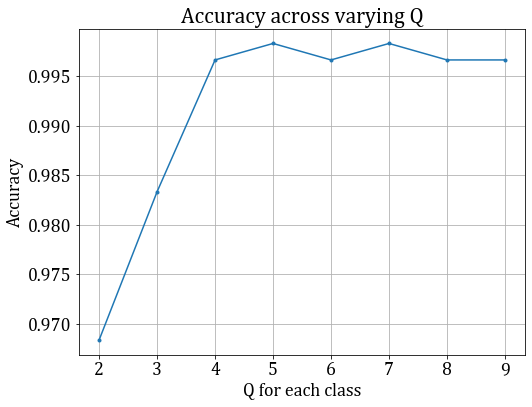

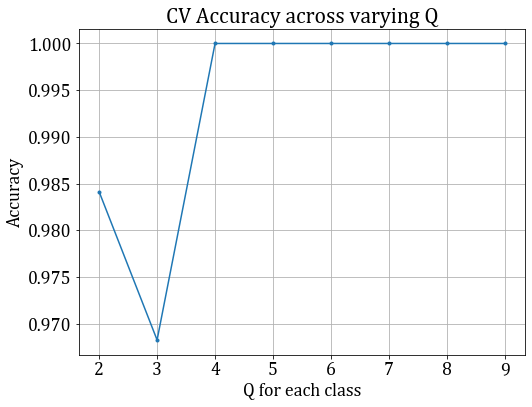

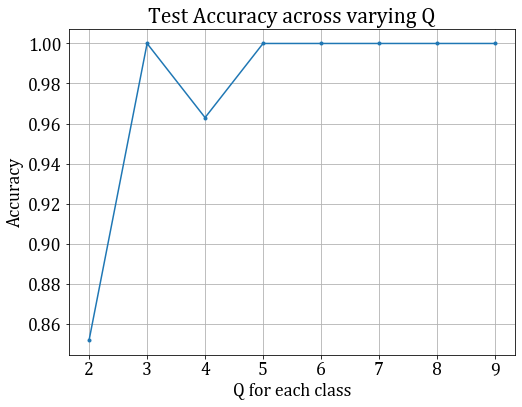

In [7]:
plt.plot(q_list, accuracy_list, '.-')
plt.title("Accuracy across varying Q")
plt.xlabel("Q for each class")
plt.ylabel("Accuracy")
plt.show()

plt.plot(q_list, cv_accuracy_list, '.-')
plt.title("CV Accuracy across varying Q")
plt.xlabel("Q for each class")
plt.ylabel("Accuracy")
plt.show()

plt.plot(q_list, test_accuracy_list, '.-')
plt.title("Test Accuracy across varying Q")
plt.xlabel("Q for each class")
plt.ylabel("Accuracy")
plt.show()

In [8]:
fout = open("1b_gmm_results", "rb")
gmm_list = pickle.load(fout)
fout.close()

Text(0.5, 1.0, 'Contour Plot - Full Covariance')

<Figure size 576x432 with 0 Axes>

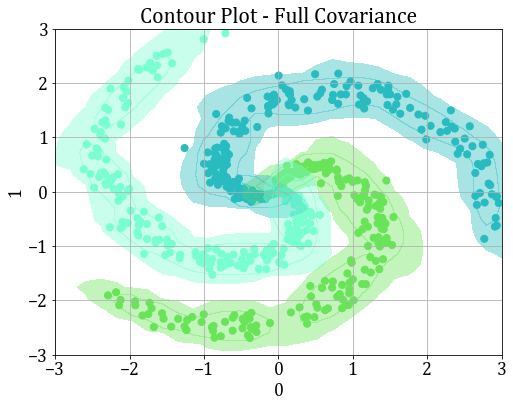

In [9]:
classes = np.unique(df[2])
q_list = list(range(2,10))

color_list = np.random.rand(len(classes), 3)
x, y = np.mgrid[-3:3:30j, -3:3:30j]
xy = np.column_stack([x.flat, y.flat])

z0 = gmm_list[0.0][3].gaussian_val(xy)
z0 = z0.reshape(x.shape)

z1 = gmm_list[1.0][3].gaussian_val(xy)
z1 = z1.reshape(x.shape)

z2 = gmm_list[2.0][3].gaussian_val(xy)
z2 = z2.reshape(x.shape)

plt.figure()
df.plot.scatter(0, 1, c=[color_list[int(i)] for i in df[2]], s=50)
plt.contourf(x, y, z0, levels=np.logspace(-2,2,5), alpha=0.4, colors=color_list[0])
plt.contourf(x, y, z1, levels=np.logspace(-2,2,5), alpha=0.4, colors=color_list[1])
plt.contourf(x, y, z2, levels=np.logspace(-2,2,5), alpha=0.4, colors=color_list[2])
plt.title("Contour Plot - Full Covariance")

<Figure size 576x432 with 0 Axes>

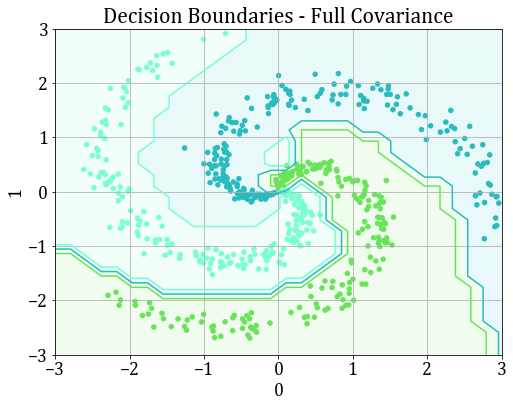

In [10]:
x, y = np.mgrid[-3:3:30j, -3:3:30j]
xy = np.column_stack([x.flat, y.flat])

z0_val = gmm_list[0.0][3].indv_log_likelihood(xy)
z1_val = gmm_list[1.0][3].indv_log_likelihood(xy)
z2_val = gmm_list[2.0][3].indv_log_likelihood(xy)

d = np.hstack((z0_val, z1_val, z2_val))
classes = np.argmax(d, axis=1)
classes = classes.reshape(x.shape)

plt.figure()
df.plot.scatter(0, 1, c=[color_list[int(i)] for i in df[2]], alpha=1)
plt.contourf(x, y, classes, 2, colors=color_list, alpha=0.1)
plt.contour(x, y, classes, 2, colors=color_list, alpha=1)
plt.title("Decision Boundaries - Full Covariance")
plt.show()